## Création d'un modele avec les données propres

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
import re
import xgboost as xgb

In [2]:
data_full = pd.read_csv("immos_paris_dataset_clean.csv",index_col=0)

In [3]:
data_full.shape

(2675, 29)

In [4]:
columns = data_full.columns.values
columns

array(['typeof', 'surface', 'field_surface', 'rooms', 'bedrooms',
       'balcony', 'parking', 'price', 'terrace_OUI', 'pool_OUI',
       'district_10', 'district_11', 'district_12', 'district_13',
       'district_14', 'district_15', 'district_16', 'district_17',
       'district_18', 'district_19', 'district_2', 'district_20',
       'district_3', 'district_4', 'district_5', 'district_6',
       'district_7', 'district_8', 'district_9'], dtype=object)

In [5]:
data_full['price'].describe()

count    2.675000e+03
mean     2.734850e+06
std      2.490664e+06
min      3.950000e+05
25%      1.395000e+06
50%      1.995000e+06
75%      3.200000e+06
max      4.200000e+07
Name: price, dtype: float64

#### Test de suppression des prix trop important pour voir la modification sur la qualité du modele
Ca fonctionne mais pas sur que ca soit une bonne idée , la MAE passe de 635k à 397K , quand on supprime ces biens

In [6]:
data_full.shape

(2675, 29)

In [7]:
important_prices = data_full.loc[data_full['price'] > 6000000]
print(len(important_prices))

175


In [8]:
print(len(important_prices)/data_full.shape[0]*100)

6.5420560747663545


In [9]:
data_full = data_full.drop(important_prices.index, axis=0)

In [10]:
data_full.shape

(2500, 29)

In [11]:
data_full['price'].describe()

count    2.500000e+03
mean     2.267882e+06
std      1.188993e+06
min      3.950000e+05
25%      1.369750e+06
50%      1.950000e+06
75%      2.850000e+06
max      6.000000e+06
Name: price, dtype: float64

Log Price
- penser a exp les predictions pour avoir le vrai chiffre

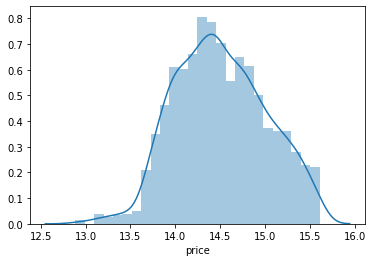

In [12]:
data_full['price'] = np.log(data_full['price'])
sns.distplot(data_full['price'])

#### Split Train / Val

In [13]:
target_column = 'price'
y_train_full_log = data_full[target_column].values
X_train_full = data_full.drop(target_column, axis=1).values

In [14]:
SEED = 42
np.random.seed(SEED)

In [15]:
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train_full, y_train_full_log, test_size=0.2)

In [16]:
print(f"Train full shape : {data_full.shape}")
print(f"X_train shape : {X_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_train_log shape : {y_train_log.shape}")
print(f"y_val_log shape : {y_val_log.shape}")

Train full shape : (2500, 29)
X_train shape : (2000, 28)
X_val shape : (500, 28)
y_train_log shape : (2000,)
y_val_log shape : (500,)


#### Scaler
Essai pour trouver le meilleur scaler pour nos datas

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [18]:
scalers = [
    MinMaxScaler(),
    MaxAbsScaler(),
    StandardScaler(),
    RobustScaler(),
    Normalizer(),
    QuantileTransformer(),
    PowerTransformer()
]

In [19]:
print("Recherche du meilleur scaler pour nos données")
print("_____________________________________________")
best_score = 0
best_scaler = "Null" 
for scaler in scalers:
    pipe = Pipeline(steps=[('scaler', scaler),('Ridge', Ridge())])
    pipe.fit(X_train,y_train_log)
    print(scaler)
    score = pipe.score(X_val,y_val_log)
    print(score)
    if score > best_score:
        best_score = score
        best_scaler = scaler    
    print("_____________________________________________")
print(f"Meilleur scaler {best_scaler} , score : {best_score}")

Recherche du meilleur scaler pour nos données
_____________________________________________
MinMaxScaler(copy=True, feature_range=(0, 1))
0.7295500960438284
_____________________________________________
MaxAbsScaler(copy=True)
0.7297151347294739
_____________________________________________
StandardScaler(copy=True, with_mean=True, with_std=True)
0.730307645254337
_____________________________________________
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
0.7280193253697345
_____________________________________________
Normalizer(copy=True, norm='l2')
0.1716102106546692
_____________________________________________
QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
0.8051263486140072
_____________________________________________
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

#### Pipeline

In [20]:
steps = [('scaler', best_scaler) , ('Ridge', Ridge())]
pipeline = Pipeline(steps)

In [21]:
parameters = {'Ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],'Ridge__alpha': [1e-5,1e-4,1e-3,1,2]}

In [22]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [23]:
grid.fit(X_train,y_train_log)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        PowerTransformer(copy=True,
                                                         method='yeo-johnson',
                                                         standardize=True)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'Ridge__alpha': [1e-05, 0.0001, 0.001, 1, 2],
                         'Ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr',
 

In [24]:
# Verifie la perfomance sur le val set ? 
# Utilise le scorer du modele si pas précisé dans scoring ? Ridge = R2
grid.score(X_val,y_val_log)

0.8332775325701175

In [25]:
grid.best_params_

{'Ridge__alpha': 2, 'Ridge__solver': 'sparse_cg'}

In [26]:
y_val_log_predict = grid.best_estimator_.predict(X_val)

In [27]:
print(f" MAE sur val : { round(mean_absolute_error(np.exp(y_val_log),np.exp(y_val_log_predict)),2) } Euros ")

 MAE sur val : 397497.9 Euros 


In [28]:
# Verification que grid.score = R2
from sklearn.metrics import r2_score
r2_score(y_val_log, y_val_log_predict)

0.8332775325701175

MAPE , 16%

In [29]:
np.mean(np.abs((np.exp(y_val_log) - np.exp(y_val_log_predict)) / np.exp(y_val_log))) * 100

16.53445971390381

In [30]:
# Enregistre le modele
pickle.dump(grid, open('realestate_model.pickle', 'wb'))

#### Test prédiction sur nouvel input

[Lien vers l'annonce pour le test](https://www.lux-residence.com/fr/vente/appartement/ILE+DE+FRANCE/75/PARIS+17E/A3A40C51-4A47-B630-ADF8-759C5F39D149/?mea=0CONTACT)

In [31]:
data_full.head(1)

,typeof,surface,field_surface,rooms,bedrooms,balcony,parking,price,terrace_OUI,pool_OUI,...,district_19,district_2,district_20,district_3,district_4,district_5,district_6,district_7,district_8,district_9
2,1,377.0,0.0,9.0,4.0,1.0,2.0,15.547166,0,0,...,0,0,0,0,0,0,0,0,0,0


Pour choisir la ville sans avoir a tout tapper , ou copier/coller ( sera utile dans le code de l'API ) 
- on cherche toutes les colonnes qui commence par " localisation_ " 
- On fait un dictionnaire avec ces colonnes avec toutes les valeurs à zéro
- On passe une des clés a 1 ( la ville ou on veut faire la prédiction )
- Et on ajoute enfin ce dictionnaire au premier dictionnaire comprenant le début du nouvel input dont on veut prédire le prix

In [32]:
list_districts = []
for column in columns:
    district = re.search("^district_",column)
    if(district):
        list_districts.append(column)

In [33]:
list_districts

['district_10',
 'district_11',
 'district_12',
 'district_13',
 'district_14',
 'district_15',
 'district_16',
 'district_17',
 'district_18',
 'district_19',
 'district_2',
 'district_20',
 'district_3',
 'district_4',
 'district_5',
 'district_6',
 'district_7',
 'district_8',
 'district_9']

In [34]:
# Création d'une liste des districts pour affichage dans l'interface avec Flask
list_districts_num = []
for district in list_districts:
    district_num = district.replace("district_","")
    list_districts_num.append(district_num)
print(list_districts_num)

['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


In [35]:
pickle.dump(list_districts_num, open('districts_num.pickle', 'wb'))

In [36]:
dict_district = { i : [0] for i in list_districts }

In [37]:
dict_district

{'district_10': [0],
 'district_11': [0],
 'district_12': [0],
 'district_13': [0],
 'district_14': [0],
 'district_15': [0],
 'district_16': [0],
 'district_17': [0],
 'district_18': [0],
 'district_19': [0],
 'district_2': [0],
 'district_20': [0],
 'district_3': [0],
 'district_4': [0],
 'district_5': [0],
 'district_6': [0],
 'district_7': [0],
 'district_8': [0],
 'district_9': [0]}

In [38]:
dict_district['district_17'] = [1]

In [39]:
dict = {
    'typeof': [1],
    'surface': [70],
    'field_surface': [0],
    'rooms': [5],
    'bedrooms': [1],
    'balcony': [0],
    'parking': [0],
    'terrace_OUI': [0],
    'pool_OUI': [0]
}

In [40]:
dict.update(dict_district)

In [41]:
dict

{'typeof': [1],
 'surface': [70],
 'field_surface': [0],
 'rooms': [5],
 'bedrooms': [1],
 'balcony': [0],
 'parking': [0],
 'terrace_OUI': [0],
 'pool_OUI': [0],
 'district_10': [0],
 'district_11': [0],
 'district_12': [0],
 'district_13': [0],
 'district_14': [0],
 'district_15': [0],
 'district_16': [0],
 'district_17': [1],
 'district_18': [0],
 'district_19': [0],
 'district_2': [0],
 'district_20': [0],
 'district_3': [0],
 'district_4': [0],
 'district_5': [0],
 'district_6': [0],
 'district_7': [0],
 'district_8': [0],
 'district_9': [0]}

In [42]:
df_pred = pd.DataFrame(dict)
df_pred

,typeof,surface,field_surface,rooms,bedrooms,balcony,parking,terrace_OUI,pool_OUI,district_10,...,district_19,district_2,district_20,district_3,district_4,district_5,district_6,district_7,district_8,district_9
0,1,70,0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_new = df_pred.values

In [44]:
X_new

array([[ 1, 70,  0,  5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

### Prediction
Test avec l'input

In [45]:
new_pred2 = grid.best_estimator_.predict(X_new)

In [46]:
int(np.exp(new_pred2[0]))

936004

Le bien est annoncé à la vente à 1 085 000Euros

In [ ]:
# model = pickle.load(open('realestate_model', 'rb'))